In [1]:
#importing dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import csv
rng = np.random

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    
    return array[idx]

In [3]:
def refine_data(arr1,arr2):
    refined_data = []
    for i in range(arr1.shape[0]):
        rt = find_nearest(arr1[i],arr2[i])
        refined_data.append(rt.round(4))
        
    refined_data = np.array(refined_data)
    
    return refined_data

In [4]:
def get_metrics(arr1,arr2):
    mse = mean_squared_error(arr1,arr2)
    r2 = r2_score(arr1,arr2)
    return mse,r2

In [5]:
#Loading dataset
d1 = pd.read_csv('X_data_t3',sep = ',')
d2 = pd.read_csv('y_data',sep = ',')
d3 = pd.concat([d1,d2],axis=1)

data = d3.loc[(d3['maxRT_ab'] < 6e7) & (d3['maxRT_ab'] > 5e5)]

features = data[['rt','maxRT_t','maxRT_ab','maxRT_base','x_start_t','x_start_ab','x_start_base','diff_start','x_end_t','x_end_ab','x_end_base','diff_end','width']]
labels = data[['y_left_t','y_right_t']]



time = pd.read_csv('time',sep = ',',header = None).dropna(axis = 'columns').round(4)
time = time[time.index.isin(data.index)]
abundance = pd.read_csv('abundance',sep = ',',header = None).dropna(axis = 'columns').round()
abundance = abundance[abundance.index.isin(data.index)]

In [6]:
#Splitting data into train and test sets
test_size = 0.3
Xtrain,Xtest,ytrain,ytest,ttrain,ttest,atrain,atest = train_test_split(features,labels,time,abundance,test_size=test_size,random_state=42)

In [7]:
#Splitting data into left and right end points
Xleft_train = np.array(Xtrain[['rt','maxRT_t','maxRT_ab','maxRT_base','x_start_t','x_start_ab','x_start_base','diff_start','width']])
Xleft_test = np.array(Xtest[['rt','maxRT_t','maxRT_ab','maxRT_base','x_start_t','x_start_ab','x_start_base','diff_start','width']])

Xright_train = np.array(Xtrain[['rt','maxRT_t','maxRT_ab','maxRT_base','x_end_t','x_end_ab','x_end_base','diff_end','width']])
Xright_test = np.array(Xtest[['rt','maxRT_t','maxRT_ab','maxRT_base','x_end_t','x_end_ab','x_end_base','diff_end','width']])

yleft_train = np.array(ytrain['y_left_t'])
yleft_test = np.array(ytest['y_left_t'])

yright_train = np.array(ytrain['y_right_t'])
yright_test = np.array(ytest['y_right_t'])

ttrain = np.array(ttrain)
ttest = np.array(ttest)

atrain = np.array(atrain)
atest = np.array(atest)

In [8]:
#Normalizing training set
scaler_left_train = MinMaxScaler()
Xleft_train = scaler_left_train.fit_transform(Xleft_train)

scaler_right_train = MinMaxScaler()
Xright_train = scaler_right_train.fit_transform(Xright_train)

In [9]:
#Normalizing test set
scaler_left_test = MinMaxScaler()
Xleft_test = scaler_left_test.fit_transform(Xleft_test)

scaler_right_test = MinMaxScaler()
Xright_test = scaler_right_test.fit_transform(Xright_test)

In [10]:
#Defining training parameters

#Learning rate
lr = 0.0001

#Number of epochs for which the model will run
epochs = 1000000

In [11]:
#Define features and label placeholders

#Features
X_left = tf.placeholder(tf.float32,shape = [None,Xleft_train.shape[1]])
X_right = tf.placeholder(tf.float32,shape = [None,Xright_train.shape[1]])

#Labels
y_left = tf.placeholder(tf.float32,shape = [None])
y_right = tf.placeholder(tf.float32,shape = [None])

In [12]:
#Define hyperparameters

#Weight
W_left = tf.cast(tf.Variable(np.random.randn(Xleft_train.shape[1],1),name="weight_left"),tf.float32)
W_right = tf.cast(tf.Variable(np.random.randn(Xright_train.shape[1],1),name="weight_right"),tf.float32)

#Bias
b_left = tf.Variable(np.random.randn(),name="bias_left")
b_right = tf.Variable(np.random.randn(),name="bias_right")


Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#Initialize all variables
init = tf.global_variables_initializer()

In [14]:
#Define cost function, optimizer and the output predictions functions

#Predictions
y_hat_left = tf.add(tf.matmul(X_left,W_left),b_left)
y_hat_right = tf.add(tf.matmul(X_right,W_right),b_right)

#Cost functions
#MSE
cost_left = tf.reduce_mean(tf.square(y_left-y_hat_left))
cost_right = tf.reduce_mean(tf.square(y_right-y_hat_right))

#Gradient Descent Optimizer to minimize the cost
optimizer_left = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost_left)
optimizer_right = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost_right)

In [15]:
#Tensor to store the cost after every Epoch
#Comes in handy while plotting the cost vs epoch
cost_history_left = np.empty(shape = [1],dtype = float)
cost_history_right = np.empty(shape = [1],dtype = float)

In [16]:
#Training the model

with tf.Session() as sess:
    #initialize all variables
    sess.run(init)
    
    for epoch in range(0,epochs):
        
        #Run the optimizer and the cost functions
        result_left,err_left = sess.run([optimizer_left,cost_left],feed_dict ={X_left:Xleft_train,y_left:yleft_train})
        result_right,err_right = sess.run([optimizer_right,cost_right],feed_dict ={X_right:Xright_train,y_right:yright_train})
        
        #Add the calculated cost to the array
        cost_history_left = np.append(cost_history_left,err_left)
        cost_history_right = np.append(cost_history_right,err_right)
        
        #Print the loss/error after every 100000 epochs
        if epoch%100000 == 0:
            print('Epoch: {0}, Error_left: {1}, Error_right: {2}'.format(epoch,err_left,err_right))
    
    print('Epoch: {0}, Error_left: {1}, Error_right: {2}'.format(epoch+1,err_left,err_right))
    
    #Values of Weight and Bias after training
    
    new_W_left = sess.run(W_left)
    new_b_left = sess.run(b_left)
    
    new_W_right = sess.run(W_right)
    new_b_right = sess.run(b_right)
    
    #Predicted labels
    ypred_left = sess.run(y_hat_left, feed_dict = {X_left:Xleft_test}).round(4)
    ypred_left_refined = refine_data(ttest,ypred_left)
    
    ypred_right = sess.run(y_hat_right, feed_dict = {X_right:Xright_test}).round(4)
    ypred_right_refined = refine_data(ttest,ypred_right)
    
    #Mean Squared Error
    mse_left = sess.run(tf.reduce_mean(tf.square(ypred_left_refined-yleft_test)))
    mse_right = sess.run(tf.reduce_mean(tf.square(ypred_right_refined-yright_test)))
    
    
        

Epoch: 0, Error_left: 5.000979423522949, Error_right: 1.4204423427581787
Epoch: 100000, Error_left: 0.02401220053434372, Error_right: 0.025880951434373856
Epoch: 200000, Error_left: 0.011511999182403088, Error_right: 0.010983115062117577
Epoch: 300000, Error_left: 0.006495821289718151, Error_right: 0.008991332724690437
Epoch: 400000, Error_left: 0.004033615812659264, Error_right: 0.008301819674670696
Epoch: 500000, Error_left: 0.0026830679271370173, Error_right: 0.007913908921182156
Epoch: 600000, Error_left: 0.0018846401944756508, Error_right: 0.007626106962561607
Epoch: 700000, Error_left: 0.0013928530970588326, Error_right: 0.007386535406112671
Epoch: 800000, Error_left: 0.0010811673710122705, Error_right: 0.007179737091064453
Epoch: 900000, Error_left: 0.0008750726119615138, Error_right: 0.0069992924109101295
Epoch: 1000000, Error_left: 0.0007378911832347512, Error_right: 0.006840539630502462


In [17]:
#Predicted Values
print("Predicted Values refined:\n", ypred_left_refined)

Predicted Values refined:
 [0.9767 0.99   0.92   0.9766 1.03   0.9733 0.9733 0.9933 1.     0.9833
 1.03   0.9633 1.0167 1.0233 0.9767 0.99   1.0233 0.98   0.9667 0.98
 0.9766 0.9933 0.9667 0.9733 0.99   0.98   0.9833 1.0366 1.07   0.9933
 1.0166 0.9733 0.9967 0.9766 0.9567 0.9733 1.0133 0.9966 0.9767 1.
 0.9966 0.9967 0.9467 0.9833 1.01   0.9466 0.9566]


In [18]:
#Actual Values
print("Actual Values:\n", yleft_test)

Actual Values:
 [0.98  0.973 0.977 0.993 0.98  0.983 0.977 0.993 0.997 0.997 0.98  0.997
 0.983 0.997 0.977 0.967 0.977 0.97  0.983 1.01  0.977 0.983 0.983 0.98
 1.003 1.003 0.997 0.983 1.    0.98  0.99  0.983 0.997 0.987 0.977 0.977
 1.003 0.983 1.01  1.013 0.987 0.983 0.987 0.993 0.983 0.98  0.987]


In [19]:
#MSE
print("Mean Squared Error [Tf Session]:", mse_left,mse_right)

Mean Squared Error [Tf Session]: 0.000701014680851064 0.004823420000000004


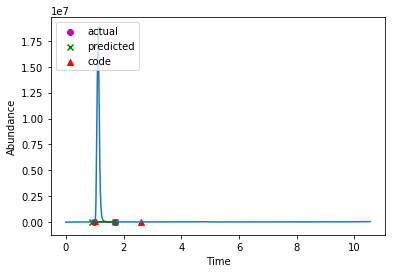

In [26]:
#%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib.figure import Figure

#Printing output for certain rows
dd = 2 #which dataset to show

Xleft_test = scaler_left_test.inverse_transform(Xleft_test)
Xright_test = scaler_right_test.inverse_transform(Xright_test)

tleft_actual = find_nearest(ttest[dd],yleft_test[dd])
aleft_actual = atest[dd][ttest[dd].tolist().index(tleft_actual)]

tright_actual = find_nearest(ttest[dd],yright_test[dd])
aright_actual = atest[dd][ttest[dd].tolist().index(tright_actual)]


tleft_pred = find_nearest(ttest[dd],ypred_left_refined[dd])
aleft_pred = atest[dd][ttest[dd].tolist().index(tleft_pred)]

tright_pred = find_nearest(ttest[dd],ypred_right_refined[dd])
aright_pred = atest[dd][ttest[dd].tolist().index(tright_pred)]


tleft_code = find_nearest(ttest[dd],Xleft_test[dd][4])
aleft_code = atest[dd][ttest[dd].tolist().index(tleft_code)]

tright_code = find_nearest(ttest[dd],Xright_test[dd][4])
aright_code = atest[dd][ttest[dd].tolist().index(tright_code)]

ax1 = plt.axes()
ax1.set_xlabel('Time')
ax1.set_ylabel('Abundance')
ax1.plot(ttest[dd],atest[dd],label=None)
ax1.scatter(tleft_actual,aleft_actual,color = 'm',marker = 'o', label = 'actual')
ax1.scatter(tleft_pred,aleft_pred,color = 'g', marker = 'x',label = 'predicted')
ax1.scatter(tleft_code,aleft_code,color = 'r', marker = '^',label = 'code')

ax1.scatter(tright_actual,aright_actual,color = 'm',marker = 'o')
ax1.scatter(tright_pred,aright_pred,color = 'g', marker = 'x')
ax1.scatter(tright_code,aright_code,color = 'r', marker = '^')


ax1.plot([tleft_actual,tright_actual],[aleft_actual,aright_actual],color = 'm')
ax1.plot([tleft_pred,tright_pred],[aleft_pred,aright_pred],color = 'g')

ax1.legend(loc = "upper left")
#ax1.set_xlim(0.25,2)


In [21]:
tleft_code,aleft_code, tright_code,aright_code

(0.99, 22428.0, 1.29, 246047.0)

In [22]:
mse1_left,r2_left = get_metrics(yleft_test,ypred_left_refined)
mse1_right,r2_right = get_metrics(yright_test,ypred_right_refined)
        
        
print(r2_left,r2_right)
print(mse1_left,mse1_right)


-5.073950099628174 -0.15693834778420301
0.000701014680851064 0.004823420000000003


In [23]:
Xleft_test = scaler_left_test.inverse_transform(Xleft_test)
Xleft_test[1][3]

7552377518.043371